In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from sklearn.preprocessing import StandardScaler

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../data/globalterrorismdb_0617dist.csv', encoding = 'latin-1', low_memory=False)

df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [3]:
df.columns
#df.AttackTypeText

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [4]:
df.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackTypeText','attacktype1': 'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_Type','weaptype1_txt':'Weapon_Type','motive':'Motive', 'latitude': 'Latitude', 'longitude': 'Longitude', 'success': 'Success'},inplace=True)
df.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','city': 'City', 'country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackTypeText','attacktype1': 'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_Type','weaptype1_txt':'Weapon_Type','motive':'Motive', 'latitude': 'Latitude', 'longitude': 'Longitude', 'casualities': "Casualties", 'ransom': 'Ransom', 'ransomamt': 'Ransom_Amount', 'ransompaid': 'Ransom_Paid'},inplace=True)

In [5]:
terror=df[['Year','Month','Day','Country','Region','City','Latitude','Longitude','AttackTypeText','AttackType','Killed','Wounded','Target','Summary','Group','Target_Type','Weapon_Type','Motive', 'Success','Ransom','Ransom_Amount', 'Ransom_Paid', 'INT_ANY']].copy()
terror['Casualties']=terror['Killed']+terror['Wounded']
terror.head(3)

,Year,Month,Day,Country,Region,City,Latitude,Longitude,AttackTypeText,AttackType,...,Group,Target_Type,Weapon_Type,Motive,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1,...,MANO-D,Private Citizens & Property,Unknown,NaN,1,0.0,NaN,NaN,0,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.432608,-99.133207,Hostage Taking (Kidnapping),6,...,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,1,1.0,800000.0,NaN,1,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1,...,Unknown,Journalists & Media,Unknown,NaN,1,0.0,NaN,NaN,1,1.0


In [6]:
terror.isnull().sum()

Year                   0
Month                  0
Day                    0
Country                0
Region                 0
City                 446
Latitude            4606
Longitude           4606
AttackTypeText         0
AttackType             0
Killed              9682
Wounded            15325
Target               634
Summary            66138
Group                  0
Target_Type            0
Weapon_Type            0
Motive            121764
Success                0
Ransom             94037
Ransom_Amount     169071
Ransom_Paid       169643
INT_ANY                0
Casualties         15826
dtype: int64

In [7]:
terror.Ransom.fillna(0,inplace=True)

In [8]:
successful = terror['Success'].value_counts().tolist()
top_countries = terror['Country'].value_counts()[:10].keys().tolist()

print('Total successful terrorist attacks: ',successful[0])
print('Total unsuccessful terrorist attacks: ',successful[1])
print('Total success rate: ',"{0:.2f}".format((successful[0]/(successful[0]+successful[1]))*100)+'%')

Total successful terrorist attacks:  152701
Total unsuccessful terrorist attacks:  17649
Total success rate:  89.64%


# Define Populations - Pakistan and India

In [9]:
pakistan = terror[terror['Country'] == 'Pakistan']
pakistan.head(3)

,Year,Month,Day,Country,Region,City,Latitude,Longitude,AttackTypeText,AttackType,...,Group,Target_Type,Weapon_Type,Motive,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
585,1970,11,1,Pakistan,South Asia,Karachi,24.893379,67.028061,Assassination,1,...,Unknown,Government (General),Vehicle (not to include vehicle-borne explosiv...,NaN,1,0.0,NaN,NaN,1,1.0
2144,1974,2,2,Pakistan,South Asia,Karachi,24.893379,67.028061,Bombing/Explosion,3,...,Muslim Guerrillas,Maritime,Firearms,NaN,1,0.0,NaN,NaN,1,0.0
2632,1974,12,9,Pakistan,South Asia,Peshawar,34.009667,71.579994,Bombing/Explosion,3,...,Unknown,Government (Diplomatic),Explosives/Bombs/Dynamite,NaN,1,0.0,NaN,NaN,1,2.0


In [10]:
pakistan_success = pakistan['Success'].value_counts().tolist()

print('Total successful terrorist attacks: ',pakistan_success[0])
print('Total unsuccessful terrorist attacks: ',pakistan_success[1])
print('Total success rate: ',"{0:.2f}".format((pakistan_success[0]/(pakistan_success[0]+pakistan_success[1]))*100)+'%')

Total successful terrorist attacks:  12032
Total unsuccessful terrorist attacks:  1602
Total success rate:  88.25%


In [11]:
pakistan.shape

(13634, 24)

In [12]:
len(pakistan.Target_Type.unique())

21

In [13]:
pakistan.describe()

,Year,Month,Day,Latitude,Longitude,AttackType,Killed,Wounded,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
count,13634.000000,13634.000000,13634.000000,13586.000000,13586.000000,13634.000000,13399.000000,13187.000000,13634.000000,13634.000000,4.700000e+01,3.300000e+01,13634.000000,13159.000000
mean,2009.679918,6.378466,15.471028,30.466443,69.394667,2.925847,1.696694,3.027603,0.882500,-0.135397,1.777864e+06,1.173228e+05,-6.757738,4.653849
std,6.941991,3.462525,8.849347,3.702016,2.572666,1.501510,5.506468,11.656492,0.322027,1.110226,5.419398e+06,4.326925e+05,3.955678,16.074818
min,1970.000000,0.000000,0.000000,24.659220,61.579536,1.000000,0.000000,0.000000,0.000000,-9.000000,-9.900000e+01,-9.900000e+01,-9.000000,0.000000
25%,2009.000000,3.000000,8.000000,26.633602,67.028061,2.000000,0.000000,0.000000,1.000000,0.000000,-9.900000e+01,-9.900000e+01,-9.000000,0.000000
50%,2012.000000,6.000000,15.000000,31.527031,69.920086,3.000000,0.000000,0.000000,1.000000,0.000000,6.000000e+04,0.000000e+00,-9.000000,1.000000
75%,2014.000000,9.000000,23.000000,33.986111,71.496152,3.000000,1.000000,2.000000,1.000000,0.000000,5.077365e+05,0.000000e+00,-9.000000,3.000000
max,2016.000000,12.000000,31.000000,36.533278,76.540559,9.000000,158.000000,351.000000,1.000000,1.000000,3.000000e+07,2.435400e+06,1.000000,430.000000


In [14]:
india = terror[terror['Country'] == 'India']
india.head(3)

,Year,Month,Day,Country,Region,City,Latitude,Longitude,AttackTypeText,AttackType,...,Group,Target_Type,Weapon_Type,Motive,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
1185,1972,2,22,India,South Asia,New Delhi,28.632381,77.220004,Hijacking,4,...,Palestinians,Airports & Aircraft,Explosives/Bombs/Dynamite,NaN,1,1.0,5000000.0,NaN,1,0.0
2690,1975,1,2,India,South Asia,Samastipur,25.863042,85.781004,Bombing/Explosion,3,...,Ananda Marga,Government (General),Explosives/Bombs/Dynamite,Unknown,1,0.0,NaN,NaN,0,4.0
3782,1976,5,26,India,South Asia,New Delhi,28.632381,77.220004,Bombing/Explosion,3,...,Unknown,Airports & Aircraft,Explosives/Bombs/Dynamite,NaN,1,0.0,NaN,NaN,-9,0.0


In [15]:
india_success = india['Success'].value_counts().tolist()

print('Total successful terrorist attacks: ',india_success[0])
print('Total unsuccessful terrorist attacks: ',india_success[1])
print('Total success rate: ',"{0:.2f}".format((india_success[0]/(india_success[0]+india_success[1]))*100)+'%')

Total successful terrorist attacks:  9480
Total unsuccessful terrorist attacks:  1498
Total success rate:  86.35%


In [16]:
india.shape

(10978, 24)

In [17]:
len(india.Target_Type.unique())

21

In [18]:
pakistan_dropna = pakistan.dropna()

# Start Regression Process - Pakistan


In [19]:
with pm.Model() as pakistan_reg:
    intercept = pm.Normal('Intercept', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=9)
    sigma = pm.HalfNormal('success_std', sd=.3220)
    
    mu = intercept + (beta[0]*pakistan_dropna['Year']) + (beta[1]*pakistan_dropna['Month']) + (beta[2]*pakistan_dropna['Day']) + (beta[3]*pakistan_dropna['Latitude'])\
    +beta[4]*pakistan_dropna['Longitude'] + (beta[5]*pakistan_dropna['AttackType']) + (beta[6]*pakistan_dropna['Ransom']) + (beta[7]*pakistan_dropna["INT_ANY"]) + (beta[8]*pakistan_dropna['Casualties']) 
    
    success = pm.Normal('Success', mu=mu, sd=sigma, observed=pakistan_dropna['Success'])

In [20]:
with pakistan_reg:
    start = pm.find_MAP()
    trace = pm.sample(start=start, nuts_kwargs={'target_accept' : .95, 'max_treedepth': 15})

logp = 51.759, ||grad|| = 1,416.9: 100%|██████████| 939/939 [00:00<00:00, 1152.29it/s]     
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [success_std_log__, beta, Intercept]
100%|██████████| 1000/1000 [22:28<00:00,  1.35s/it]
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7418104321384658, but should be close to 0.95. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7437577884653542, but should be

In [21]:
start

{'Intercept': array(6.0033893e-05),
 'beta': array([ 4.95527439e-04, -1.04172458e-04,  6.09182262e-05, -1.13419189e-04,
         1.14621814e-04, -3.20793394e-04, -1.54838977e-04, -2.61735862e-05,
        -2.93142915e-05]),
 'success_std': array(0.00074889),
 'success_std_log__': array(-7.19692383)}

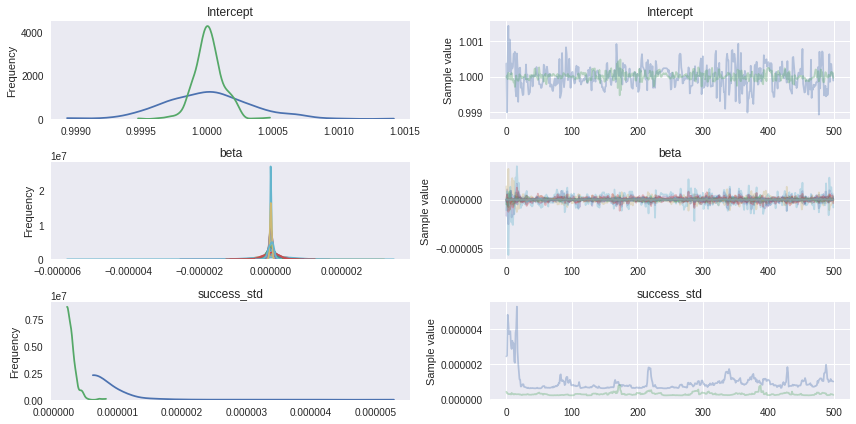

In [22]:
pm.traceplot(trace);

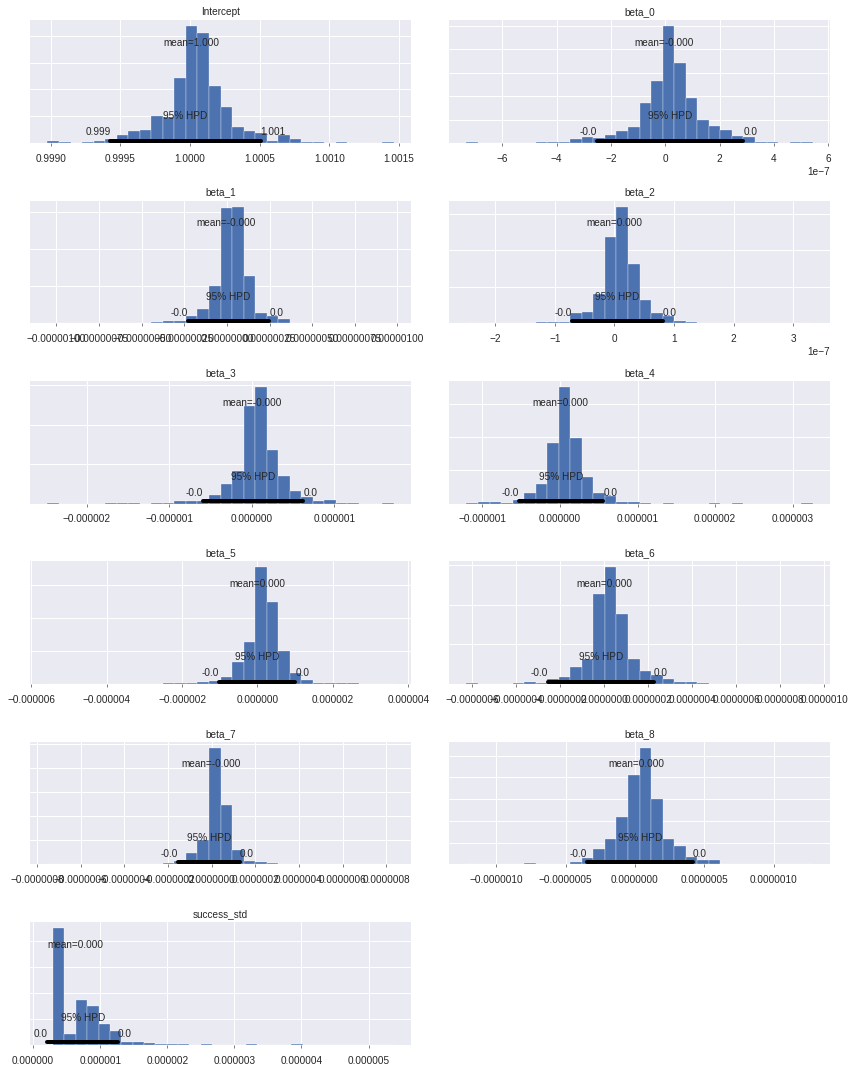

In [23]:
pm.plot_posterior(trace);

# Start Regression Process - India

In [24]:
india.describe()

,Year,Month,Day,Latitude,Longitude,AttackType,Killed,Wounded,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
count,10978.000000,10978.000000,10978.000000,10822.000000,10822.000000,10978.000000,10774.000000,10565.000000,10978.000000,10978.000000,1.020000e+02,89.000000,10978.000000,10549.000000
mean,2005.297686,6.452997,15.595919,25.976377,82.795902,3.324831,1.748840,2.673071,0.863545,-0.177901,6.070217e+05,2144.186180,-4.635635,4.349227
std,9.994802,3.324406,8.776815,5.640235,7.067957,1.968358,4.839601,11.794044,0.343286,1.288330,2.868184e+06,11963.813503,4.578156,14.949807
min,1972.000000,1.000000,0.000000,8.169375,68.775724,1.000000,0.000000,0.000000,0.000000,-9.000000,-9.900000e+01,-99.000000,-9.000000,0.000000
25%,1997.000000,4.000000,8.000000,22.610968,75.341218,2.000000,0.000000,0.000000,1.000000,0.000000,-9.900000e+01,-99.000000,-9.000000,0.000000
50%,2009.000000,6.000000,15.000000,25.305252,81.872425,3.000000,0.000000,0.000000,1.000000,0.000000,1.536900e+04,-99.000000,-9.000000,1.000000
75%,2014.000000,9.000000,23.000000,31.147131,88.471270,3.000000,1.000000,1.000000,1.000000,0.000000,7.476625e+04,0.000000,0.000000,4.000000
max,2016.000000,12.000000,31.000000,34.665595,96.644737,9.000000,188.000000,817.000000,1.000000,1.000000,2.500000e+07,79555.000000,1.000000,1005.000000


In [25]:
india_dropna = india.dropna()
india_dropna.head(3)

,Year,Month,Day,Country,Region,City,Latitude,Longitude,AttackTypeText,AttackType,...,Group,Target_Type,Weapon_Type,Motive,Success,Ransom,Ransom_Amount,Ransom_Paid,INT_ANY,Casualties
69208,1999,8,3,India,South Asia,Guwahati,26.179222,91.753346,Hostage Taking (Kidnapping),6,...,Dima Halao Daoga (DHD),Business,Firearms,To obtain ransom money.,1,1.0,-99.0,-99.0,0,0.0
69217,1999,8,4,India,South Asia,Guwahati,26.179222,91.753346,Hostage Taking (Kidnapping),6,...,Dima Halao Daoga (DHD),Business,Firearms,To obtain ransom money.,1,1.0,-99.0,-99.0,0,0.0
69223,1999,8,5,India,South Asia,Kotkapura,30.580791,74.824222,Hostage Taking (Kidnapping),6,...,Khalistan Liberation Force,Private Citizens & Property,Firearms,To make money for future terrorist attacks.,1,1.0,-99.0,-99.0,0,0.0


In [26]:
with pm.Model() as india_reg:
    intercept = pm.Normal('Intercept', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=9)
    sigma = pm.HalfNormal('success_std', sd=.3432)
    
    mu = intercept + (beta[0]*india_dropna['Year']) + (beta[1]*india_dropna['Month']) + (beta[2]*india_dropna['Day']) + (beta[3]*india_dropna['Latitude'])\
    +beta[4]*india_dropna['Longitude'] + (beta[5]*india_dropna['AttackType']) + (beta[6]*india_dropna['Ransom']) + (beta[7]*india_dropna["INT_ANY"]) + (beta[8]*india_dropna['Casualties']) 
    
    success = pm.Normal('Success', mu=mu, sd=sigma, observed=india_dropna['Success'])

In [27]:
with india_reg:
    start = pm.find_MAP()
    trace = pm.sample(start=start, nuts_kwargs={'target_accept' : .95, 'max_treedepth': 15})

logp = 209, ||grad|| = 605.47: 100%|██████████| 604/604 [00:00<00:00, 1308.34it/s]        
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [success_std_log__, beta, Intercept]
100%|██████████| 1000/1000 [16:47<00:00,  1.01s/it]
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4774992965619497, but should be close to 0.95. Try to increase the number of tuning steps.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4203934198161476, but should b

In [28]:
start

{'Intercept': array(0.00042257),
 'beta': array([ 5.09765886e-04,  1.17024710e-04, -2.25257303e-05, -5.29089546e-05,
        -2.40017325e-04, -4.84209815e-04,  4.49791960e-05,  7.38932219e-05,
         1.11541432e-04]),
 'success_std': array(0.00249767),
 'success_std_log__': array(-5.99239632)}

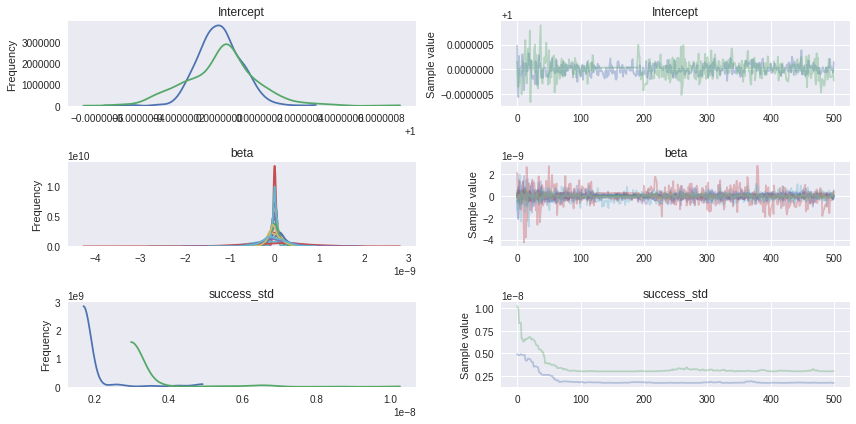

In [29]:
pm.traceplot(trace);

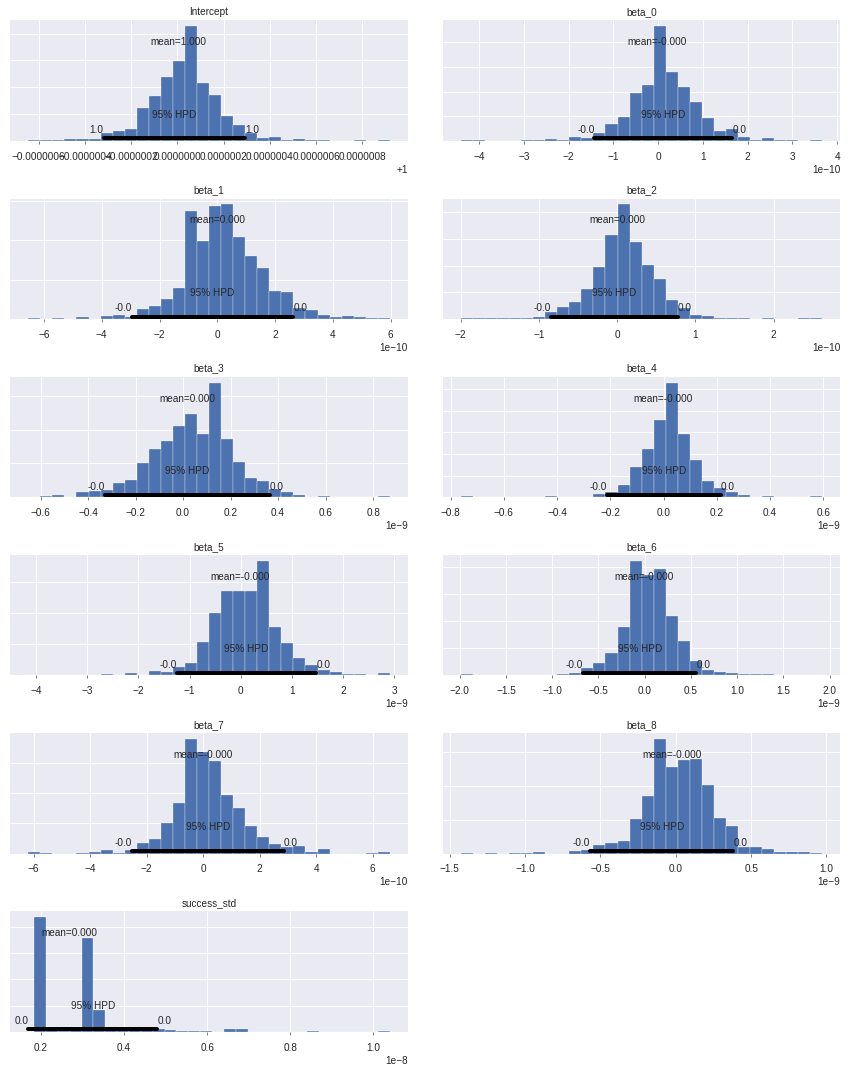

In [30]:
pm.plot_posterior(trace);

## Second and First Intifada - 1987 - 2005

In [31]:
intifada = terror[(terror.Year < 2005) & (terror.Year > 1987)]

In [ ]:
intifada.Casualities.std()

In [ ]:
intifada.head(3)

In [ ]:
intifada_prior = intifada[['Year', 'Country', 'AttackType', 'Casualties', 'Ransom', 'INT_ANY', 'Latitude','Longitude']]


In [ ]:
intifada_prior_dummies = pd.get_dummies(intifada_prior)

In [ ]:
intifada_prior_dummies.columns

In [ ]:
intifada_prior_dummies.dropna(inplace=True)

In [ ]:
intifada_prior_scaled = StandardScaler().fit_transform(intifada_prior_dummies)

In [ ]:
lebanon = intifada[(intifada.Country == 'Lebanon')]
israel = intifada[(intifada.Country == 'Israel')]

In [ ]:
intifada = pd.concat((lebanon, israel)).reset_index(drop=False)

In [ ]:
intifada.shape

In [ ]:
intifada = intifada[['Year', 'Country', 'AttackType', 'Casualties', 'Ransom', 'INT_ANY', 'Latitude','Longitude']]

In [ ]:
dummies = pd.get_dummies(intifada)

In [ ]:
dummies.dropna(inplace=True)

In [ ]:
dummies.columns

In [ ]:
intifada_scaled = StandardScaler().fit_transform(dummies)

In [ ]:
intifada_scaled = pd.DataFrame(intifada_scaled, columns=['Year', 'AttackType', 'Casualties', 'Ransom', 'INT_ANY', 'Latitude','Longitude', 'Country_Israel', 'Country_Lebanon'])

In [ ]:
intifada_scaled.head()

In [ ]:
with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=8)
    sigma = pm.HalfNormal('sigma', sd=1)

    mu = intercept + beta[0]*intifada_scaled['Year'] + \
          beta[1]*intifada_scaled['Country_Israel'] + beta[2]*intifada_scaled['Country_Lebanon']  + beta[3]*intifada_scaled['AttackType'] +\
        beta[4]*intifada_scaled['Ransom'] + beta[5]*intifada_scaled['INT_ANY'] + beta[6]*intifada_scaled['Latitude'] + beta[7]*intifada_scaled['Longitude']
    casualities = pm.Normal('Casualties', mu=mu, sd=sigma, observed=intifada_scaled['Casualties'])
    
    
    
    

In [ ]:
with model:
    start = pm.find_MAP()
    trace = pm.sample(4000, start=start)

In [ ]:
start

In [ ]:
pm.traceplot(trace);

In [ ]:
pm.plot_posterior(trace, color='#87ceeb');